In [1]:
# plotting libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# visualisations 
import geopandas as gpd 
import folium
import numpy as np 

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Heat map of median rental prices per postcode

In [4]:
# create geoJSON file of postcode and geometry coordinates 
sf = gpd.read_file("../data/raw/external/POA_2021_AUST_GDA2020.shp")
postcodes = pd.read_csv("../data/raw/external/postcode.csv", names = ["POA_CODE21", "Name", "Area"])
postcodes['POA_CODE21'] = postcodes['POA_CODE21'].astype(int)

# Convert the geometry shaape to to latitude and longitude
# TAKEN FROM TUTE 2 NOTEBOOK
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
sf = sf[sf['POA_CODE21'].between('3000', '4000')]
sf['POA_CODE21'] = sf['POA_CODE21'].astype(int)



gdf = gpd.GeoDataFrame(
    pd.merge(postcodes, sf, on='POA_CODE21', how='inner')
)

geoJSON = gdf[['POA_CODE21', 'geometry']].drop_duplicates('POA_CODE21').to_json()

In [5]:
# (y, x) since we want (lat, long)
gdf['centroid'] = gdf['geometry'].apply(lambda x: (x.centroid.y, x.centroid.x))
gdf[['Name', 'POA_CODE21', 'centroid']].head()

df = pd.read_csv(f'../data/curated/median_rental_postcode.csv')
df.reset_index()
df.rename({'Postcode': 'POA_CODE21'})

m = folium.Map(location=[-37.8136, 144.9631], tiles="Stamen Terrain", zoom_start=10)

c = folium.Choropleth(
            geo_data=geoJSON, # geoJSON 
            name='choropleth', # name of plot
            data=df, # data source
            columns=['Postcode', 'Cost'], # the columns required
            key_on='properties.POA_CODE21', # this is from the geoJSON's properties
            fill_color='YlOrRd', # color scheme
            nan_fill_color='grey',
            legend_name= 'Median Rental Prices'
        )

c.add_to(m)
m.save(f'../plots/victoria_rental_prices_heatmap')


For better comparisons, outliers with median rental prices of greater than $XX were omitted. This gave a better visualisation of the rental distribution in more suburbs

In [6]:
df.sort_values(by = ['Cost'], ascending = False)

,Postcode,Cost
183,3564,1495.165
131,3187,925.000
137,3193,850.000
148,3206,827.500
84,3126,775.000
...,...,...
206,3840,340.000
205,3825,320.000
175,3400,320.000
174,3377,315.000


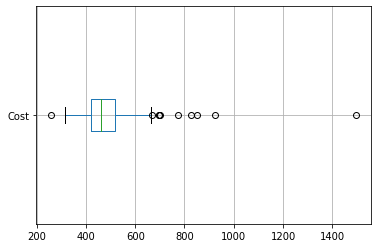

In [7]:
medianprices = df.boxplot(column = ['Cost'], vert = False)

In [8]:
df_adjusted = df[(df['Cost'] <= 700)]

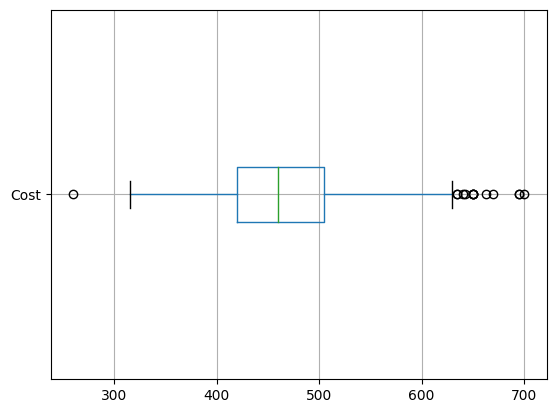

In [9]:
medianprices = df_adjusted.boxplot(column = ['Cost'], vert = False)

In [10]:
m = folium.Map(location=[-37.8136, 144.9631], tiles="Stamen Terrain", zoom_start=10)

c = folium.Choropleth(
            geo_data=geoJSON, # geoJSON 
            name='choropleth', # name of plot
            data=df_adjusted, # data source
            columns=['Postcode', 'Cost'], # the columns required
            key_on='properties.POA_CODE21', # this is from the geoJSON's properties
            fill_color='YlOrRd', # color scheme
            nan_fill_color='grey',
            legend_name= 'Median Rental Prices'
        )

c.add_to(m)
m.save(f'../plots/victoria_rental_prices_heatmap_reduced')
